Found 362 images belonging to 2 classes.
Epoch 1/10
10/10 [==============================] - 2s 83ms/step - loss: 0.6885 - accuracy: 0.5276
Epoch 2/10
10/10 [==============================] - 1s 81ms/step - loss: 0.6273 - accuracy: 0.6862
Epoch 3/10
10/10 [==============================] - 1s 81ms/step - loss: 0.6036 - accuracy: 0.7103
Epoch 4/10
10/10 [==============================] - 1s 81ms/step - loss: 0.5731 - accuracy: 0.7276
Epoch 5/10
10/10 [==============================] - 1s 81ms/step - loss: 0.5386 - accuracy: 0.7655
Epoch 6/10
10/10 [==============================] - 1s 82ms/step - loss: 0.5179 - accuracy: 0.7655
Epoch 7/10
10/10 [==============================] - 1s 84ms/step - loss: 0.5182 - accuracy: 0.7517
Epoch 8/10
10/10 [==============================] - 1s 81ms/step - loss: 0.4558 - accuracy: 0.8241
Epoch 9/10
10/10 [==============================] - 1s 83ms/step - loss: 0.4569 - accuracy: 0.8241
Epoch 10/10
3/3 [==============================] - 0s 14ms/step
Loca

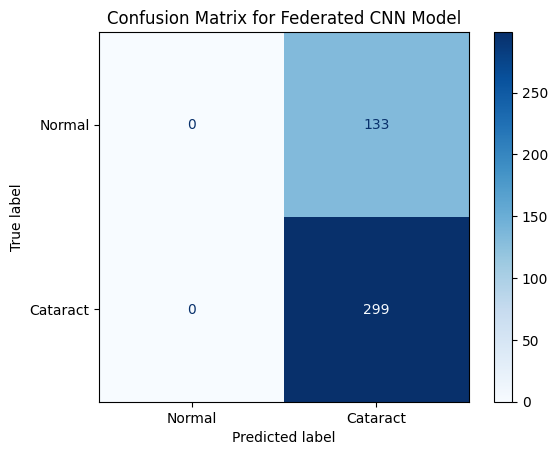

Found 94 images belonging to 2 classes.
Federated CNN Model Test Accuracy: 89.72%
Precision: 0.89
Recall: 1.00
F1-score: 0.94



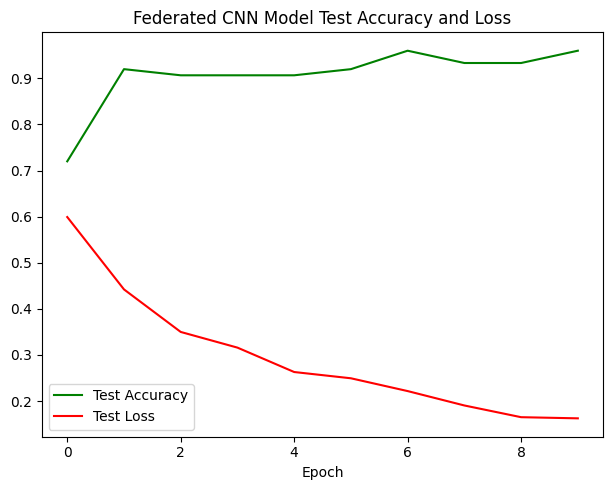

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Define the CNN-based model
def create_cnn_model():
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a function to load data from a local dataset
def load_data(client_folder):
    datagen = ImageDataGenerator(rescale=1./255)
    
    data_generator = datagen.flow_from_directory(
        client_folder,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary'
    )
    
    data, labels = [], []
    for batch in data_generator:
        data.extend(batch[0])
        labels.extend(batch[1])
        if len(data) >= data_generator.n:
            break
    
    return np.array(data), np.array(labels)

def custom_federated_averaging(global_model, local_model, weight):
    for global_layer, local_layer in zip(global_model.layers, local_model.layers):
        weights = [weight * global_w + (1 - weight) * local_w for global_w, local_w in zip(global_layer.get_weights(), local_layer.get_weights())]
        global_layer.set_weights(weights)
    return global_model

def train_local_cnn_model(local_model, data, labels, epsilon):
    history = local_model.fit(data, labels, epochs=10, batch_size=32)
    
    # Add noise to gradients for differential privacy
    for layer in local_model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            layer.set_weights([w + np.random.normal(0, epsilon, w.shape) for w in layer.get_weights()])
    
    return local_model, history

def split_train_test_data(data, labels, test_ratio=0.2):
    num_samples = len(data)
    num_test_samples = int(test_ratio * num_samples)

    indices = np.random.permutation(num_samples)
    data = data[indices]
    labels = labels[indices]

    test_data = data[:num_test_samples]
    test_labels = labels[:num_test_samples]
    train_data = data[num_test_samples:]
    train_labels = labels[num_test_samples:]

    return train_data, train_labels, test_data, test_labels

# Main block
if __name__ == '__main__':
    client_folders = ['ds1', 'ds2', 'ds3']  # Update to contain three dataset folders
    current_dir = os.getcwd()
    local_models = [create_cnn_model() for _ in client_folders]
    train_metrics = []
    test_metrics = []

    best_accuracies = [0.0] * len(client_folders)
    best_local_models = [None] * len(client_folders)

    epsilon = 0.1
    local_histories = []

    for i, client_folder in enumerate(client_folders):
        client_folder_path = os.path.join(current_dir, client_folder)
        data, labels = load_data(client_folder_path)
        train_data, train_labels, test_data, test_labels = split_train_test_data(data, labels)

        local_model, history = train_local_cnn_model(local_models[i], train_data, train_labels, epsilon)

        local_histories.append(history)

        train_loss, train_accuracy = local_models[i].evaluate(train_data, train_labels, verbose=0)
        train_predictions = (local_models[i].predict(train_data) > 0.5).astype('int32')

        train_precision = precision_score(train_labels, train_predictions)
        train_recall = recall_score(train_labels, train_predictions)
        train_f1_score = f1_score(train_labels, train_predictions)

        train_metrics.append((train_accuracy, train_precision, train_recall, train_f1_score))

        test_loss, test_accuracy = local_models[i].evaluate(test_data, test_labels, verbose=0)
        test_predictions = (local_models[i].predict(test_data) > 0.5).astype('int32')

        test_precision = precision_score(test_labels, test_predictions)
        test_recall = recall_score(test_labels, test_predictions)
        test_f1_score = f1_score(test_labels, test_predictions)

        test_metrics.append((test_accuracy, test_precision, test_recall, test_f1_score))

        test_report = classification_report(test_labels, test_predictions, target_names=['Normal', 'Cataract'], zero_division=1)
        train_report = classification_report(train_labels, train_predictions, target_names=['Normal', 'Cataract'], zero_division=1)

        print(f'Local Model {i+1} Train Accuracy: {train_accuracy * 100:.2f}%')
        print(f'Local Model {i+1} Train Precision: {train_precision:.2f}')
        print(f'Local Model {i+1} Train Recall: {train_recall:.2f}')
        print(f'Local Model {i+1} Train F1-score: {train_f1_score:.2f}\n')
        print(f'Local Model {i+1} Test Accuracy: {test_accuracy * 100:.2f}%')
        print(f'Local Model {i+1} Test Precision: {test_precision:.2f}')
        print(f'Local Model {i+1} Test Recall: {test_recall:.2f}')
        print(f'Local Model {i+1} Test F1-score: {test_f1_score:.2f}\n')
        print(f'Local Model {i+1} Classification Report (Train Data):')
        print(train_report)
        print(f'Local Model {i+1} Classification Report (Test Data):')
        print(test_report)

        if test_accuracy > best_accuracies[i]:
            best_accuracies[i] = test_accuracy
            best_local_models[i] = local_models[i]

    total_best_accuracy = sum(best_accuracies)
    weights = [accuracy / total_best_accuracy for accuracy in best_accuracies]
    global_model = create_cnn_model()

    for i, best_local_model in enumerate(best_local_models):
        global_model = custom_federated_averaging(global_model, best_local_model, weights[i])

    # Calculate global training accuracy, precision, recall, and F1-score using the metrics collected during local training
    global_train_accuracy = sum([metrics[0] for metrics in train_metrics]) / len(train_metrics)
    global_train_precision = sum([metrics[1] for metrics in train_metrics]) / len(train_metrics)
    global_train_recall = sum([metrics[2] for metrics in train_metrics]) / len(train_metrics)
    global_train_f1_score = sum([metrics[3] for metrics in train_metrics]) / len(train_metrics)

    # Display global training metrics after Federated Averaging
    print(f'Federated CNN Model Training Accuracy after Federated Averaging: {global_train_accuracy * 100:.2f}%')
    print(f'Precision: {global_train_precision:.2f}')
    print(f'Recall: {global_train_recall:.2f}')
    print(f'F1-score: {global_train_f1_score:.2f}\n')

    # Confusion matrix for global model after Federated Averaging
    global_train_predictions = (global_model.predict(train_data) > 0.5).astype('int32')
    cm_train = confusion_matrix(train_labels, global_train_predictions)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Normal', 'Cataract'])
    disp_train.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Federated CNN Model')
    plt.show()

    # Load the global test data
    global_test_folder = 'test'
    global_test_folder_path = os.path.join(current_dir, global_test_folder)
    global_test_data, global_test_labels = load_data(global_test_folder_path)

    # Test the global model on the global test data
    history_global_test = global_model.fit(global_test_data, global_test_labels, epochs=10, batch_size=32, verbose=0, validation_split=0.2)

    # Display global test metrics
    print(f'Federated CNN Model Test Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Precision: {test_precision:.2f}')
    print(f'Recall: {test_recall:.2f}')
    print(f'F1-score: {test_f1_score:.2f}\n')

    # Plot global test accuracy and loss for all 10 epochs
    plt.figure(figsize=(12, 5))

    # Plot global test accuracy in green
    plt.subplot(1, 2, 1)
    plt.plot(history_global_test.history['accuracy'], label='Test Accuracy', color='green')
    plt.plot(history_global_test.history['loss'], label='Test Loss', color='red')
    plt.title('Federated CNN Model Test Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()
